In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


2023-07-24 23:24:33.434289: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 23:24:33.469169: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
def preprocess_image(image_array):
    # Convert the image to grayscale if it's in color
    if image_array.shape[-1] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Apply adaptive thresholding
    adaptive_thresh = threshold_local(image_array, block_size=11, method='gaussian', offset=2)

    return (image_array > adaptive_thresh).astype(np.uint8) * 255

In [6]:
def detect_suit_regions(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)

    # convert image to grayscale.
    image_array = preprocess_image(image_array)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    binary_image = image_array > threshold_otsu(image_array)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = binary_erosion(binary_image)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours = find_contours(eroded_image, 0.8)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: x[:, 0].size)

    # Get the bounding box of the suit contour.
    minr, minc = np.min(suit_contour, axis=0).astype(int)
    maxr, maxc = np.max(suit_contour, axis=0).astype(int)

    # Check if the bounding box has valid dimensions (not too small).
    min_size = 10
    if maxr - minr < min_size or maxc - minc < min_size:
        print(f"Suit region too small for HOG features in {image_path}")
        return None

    # Crop the suit region from the original image.
    suit_image = image_array[minr:maxr, minc:maxc]

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(suit_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))

    return hog_features



In [7]:
# Extract the HOG features from the DataFrame and create a list of feature arrays.
hog_features_list_train = []
y_train_collected = []

for i in range(len(train_generator.filenames)):
    image_path = train_generator.filepaths[i]
    hog_features = detect_suit_regions(image_path)
    if hog_features is not None:
        # Check if the shape of the HOG features is consistent.
        if len(hog_features) == 768:  # Update this value to match the expected feature size.
            hog_features_list_train.append(hog_features)
            y_train_collected.append(train_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array (samples x features).
hog_features_array_train = np.vstack(hog_features_list_train)
y_train_collected = np.array(y_train_collected)

Suit region too small for HOG features in Dataset/train/three of clubs/002.jpg
Suit region too small for HOG features in Dataset/train/jack of hearts/110.jpg
Suit region too small for HOG features in Dataset/valid/four of spades/1.jpg
Suit region too small for HOG features in Dataset/valid/five of hearts/2.jpg
Suit region too small for HOG features in Dataset/test/eight of spades/3.jpg
Suit region too small for HOG features in Dataset/train/four of clubs/024.jpg
Suit region too small for HOG features in Dataset/train/three of spades/093.jpg
Suit region too small for HOG features in Dataset/train/four of diamonds/012.jpg
Suit region too small for HOG features in Dataset/train/three of spades/050.jpg
Suit region too small for HOG features in Dataset/train/nine of hearts/004.jpg
Suit region too small for HOG features in Dataset/train/seven of diamonds/002.jpg
Suit region too small for HOG features in Dataset/test/three of hearts/3.jpg
Suit region too small for HOG features in Dataset/trai

In [8]:
# # Extract the HOG features from the DataFrame and create a list of feature arrays.
# hog_features_list_train = []
# for i in range(len(train_generator.filenames)):
#     image_path = train_generator.filepaths[i]
#     hog_features = detect_suit_regions(image_path)
#     if hog_features is not None:
#         # Check if the shape of the HOG features is consistent.
#         if len(hog_features) == 768:  # Update this value to match the expected feature size.
#             hog_features_list_train.append(hog_features)

# # Convert the list of HOG feature arrays into a 2D array (samples x features).
# hog_features_array_train = np.vstack(hog_features_list_train)

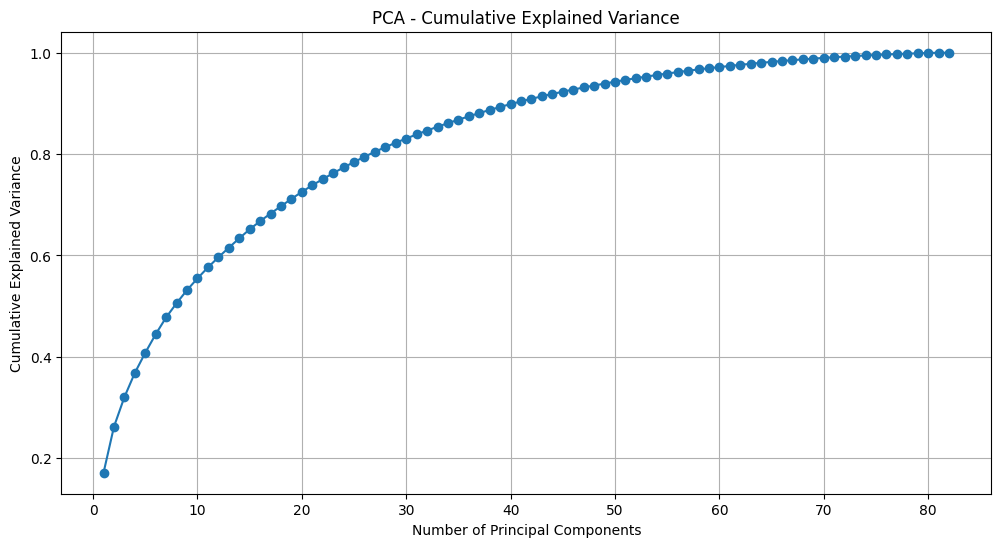

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the HOG features.
pca = PCA()
hog_features_pca = pca.fit_transform(hog_features_array_train)

# Plot the cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(12, 6))  # Adjust the width using the figsize parameter.
plt.plot(np.arange(1, hog_features_pca.shape[1] + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()


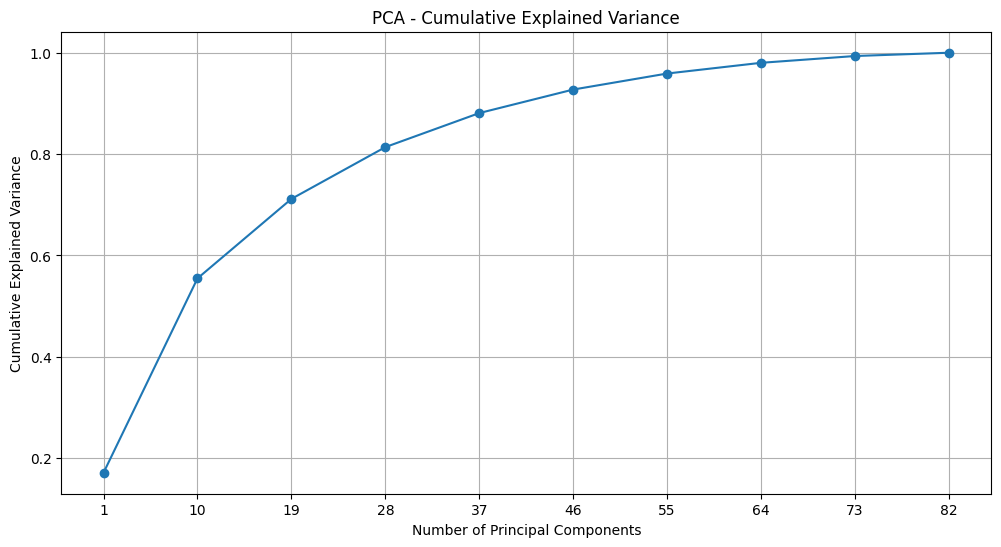

In [10]:
# Perform PCA on the HOG features.
pca = PCA()
hog_features_pca = pca.fit_transform(hog_features_array_train)

# Plot the cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of principal components to plot with increments of 10.
num_components = hog_features_pca.shape[1]
components_range = np.arange(1, num_components + 1, 9)

plt.figure(figsize=(12, 6))  # Adjust the width using the figsize parameter.
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range)
plt.grid(True)
plt.show()

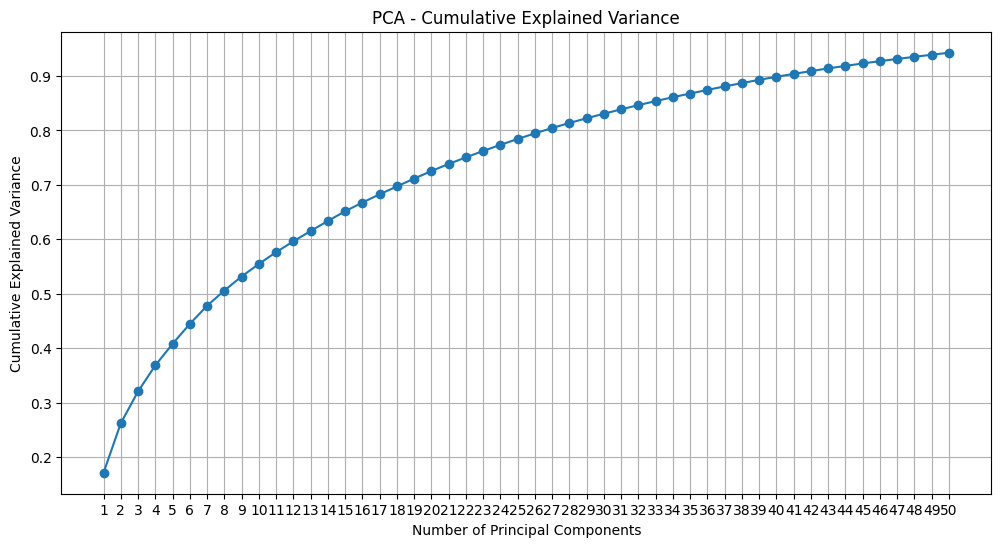

In [11]:
# Perform PCA on the HOG features.
pca = PCA()
hog_features_pca = pca.fit_transform(hog_features_array_train)

# Plot the cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of principal components to plot from 1 to 50.
components_range = np.arange(1, 51)

plt.figure(figsize=(12, 6))
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [12]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
from sklearn.preprocessing import LabelBinarizer

# One-hot encode the target labels
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train_collected)

# Normalize the HOG features
hog_features_array_train_normalized = hog_features_array_train / np.max(hog_features_array_train)

# Shuffle the data
indices = np.arange(hog_features_array_train_normalized.shape[0])
np.random.shuffle(indices)
hog_features_array_train_normalized = hog_features_array_train_normalized[indices]
y_train_one_hot = y_train_one_hot[indices]

# Split data into train and validation sets
split_ratio = 0.8
split_idx = int(hog_features_array_train_normalized.shape[0] * split_ratio)

x_train = hog_features_array_train_normalized[:split_idx]
y_train = y_train_one_hot[:split_idx]
x_val = hog_features_array_train_normalized[split_idx:]
y_val = y_train_one_hot[split_idx:]


In [14]:
input_shape = (768,)  # Update this value to match the expected feature size.
num_classes = len(label_binarizer.classes_)

model = create_cnn_model(input_shape, num_classes)
model.summary()

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)


2023-07-24 23:28:47.963924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 23:28:47.976385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 23:28:47.976419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 23:28:47.983426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-24 23:28:47.983460: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 106,948
Trainable params: 106,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-07-24 23:28:49.054788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-24 23:28:49.147573: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55723a44b2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-24 23:28:49.147615: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-24 23:28:49.183762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-24 23:28:49.231879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-24 23:28:49.436036: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

3/3 [==============================] - 1s 81ms/step - loss: 1.4368 - accuracy: 0.3077 - val_loss: 1.2651 - val_accuracy: 0.5294
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 1.3255 - accuracy: 0.4000 - val_loss: 1.2082 - val_accuracy: 0.5294
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 1.2544 - accuracy: 0.4462 - val_loss: 1.1658 - val_accuracy: 0.5294
Epoch 4/50
3/3 [==============================] - 0s 15ms/step - loss: 1.2124 - accuracy: 0.5231 - val_loss: 1.1371 - val_accuracy: 0.5294
Epoch 5/50
3/3 [==============================] - 0s 13ms/step - loss: 1.2681 - accuracy: 0.3846 - val_loss: 1.1169 - val_accuracy: 0.5294
Epoch 6/50
3/3 [==============================] - 0s 13ms/step - loss: 1.2751 - accuracy: 0.4615 - val_loss: 1.1046 - val_accuracy: 0.5294
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 1.1798 - accuracy: 0.5538 - val_loss: 1.1091 - val_accuracy: 0.5882
Epoch 8/50
3/3 [======================

## Sample Images

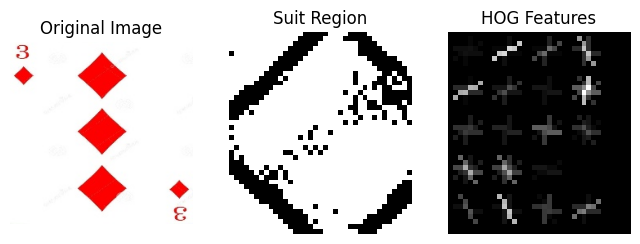

Suit region too small for HOG features in Dataset/train/three of diamonds/002.jpg


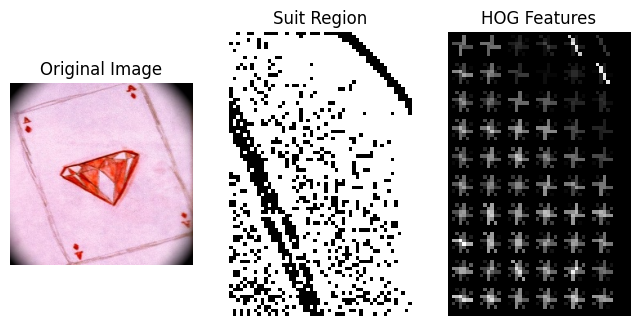

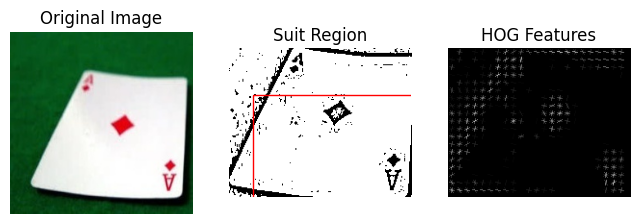

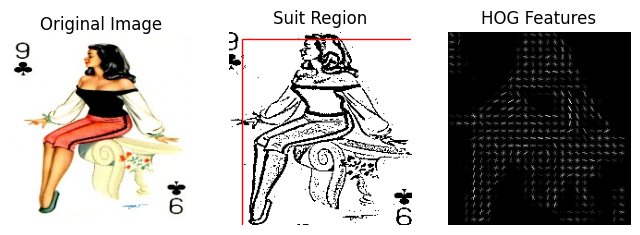

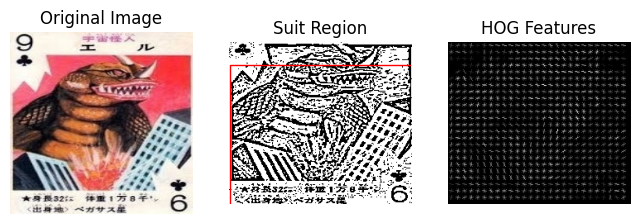

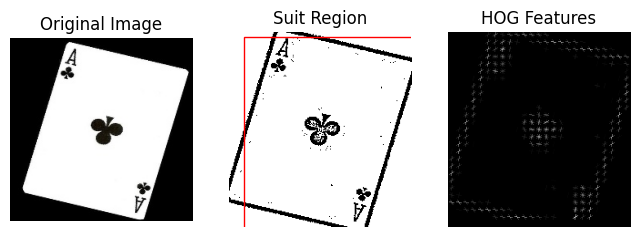

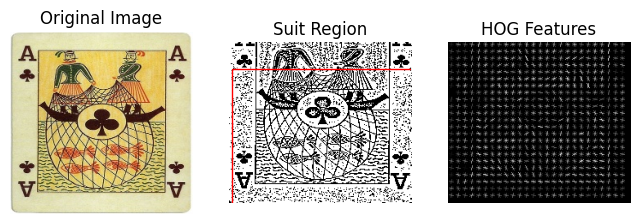

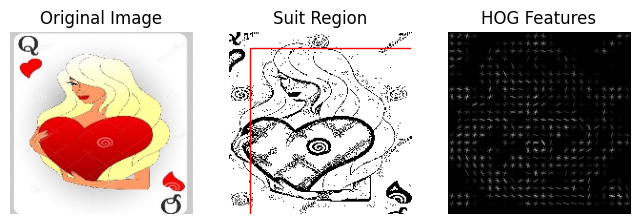

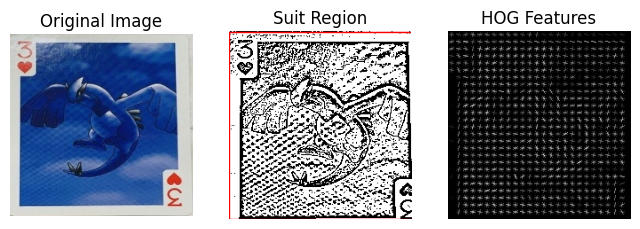

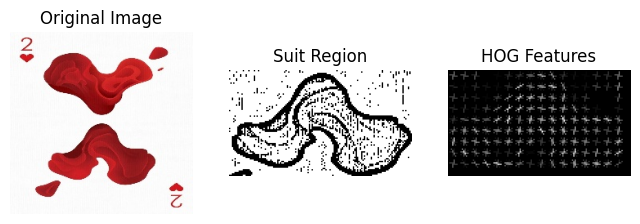

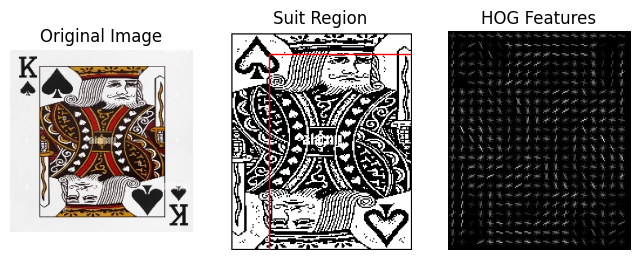

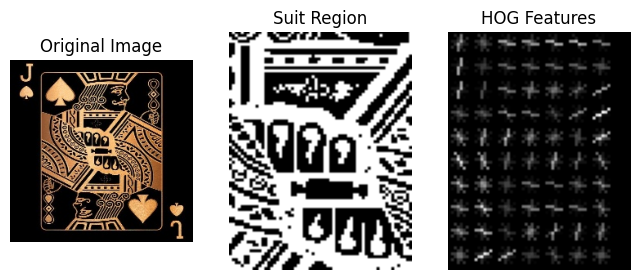

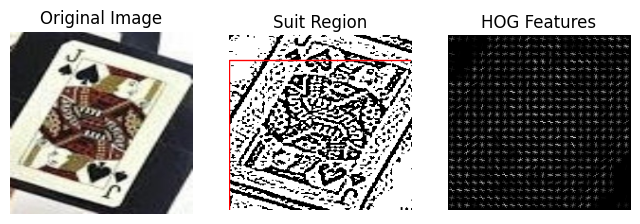

In [15]:
# Display some sample images

def detect_suit_regions(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)

    # convert image to grayscale.
    image_array = preprocess_image(image_array)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    binary_image = image_array > threshold_otsu(image_array)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = binary_erosion(binary_image)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours = find_contours(eroded_image, 0.8)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: x[:, 0].size)

    # Get the bounding box of the suit contour.
    minr, minc = np.min(suit_contour, axis=0).astype(int)
    maxr, maxc = np.max(suit_contour, axis=0).astype(int)

    # Check if the bounding box has valid dimensions (not too small).
    min_size = 10
    if maxr - minr < min_size or maxc - minc < min_size:
        print(f"Suit region too small for HOG features in {image_path}")
        return None

    # Crop the suit region from the original image.
    suit_image = image_array[minr:maxr, minc:maxc]

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(suit_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))

    # Plot the original image and the HOG features.
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[1].imshow(suit_image, cmap='gray')
    ax[1].add_patch(patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=1, edgecolor='r', facecolor='none'))
    ax[1].set_title('Suit Region')
    ax[1].axis('off')

    ax[2].imshow(hog_image, cmap='gray')
    ax[2].set_title('HOG Features')
    ax[2].axis('off')

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    plt.show()

    return hog_features


# Sample image paths
image_paths = [
    'Dataset/train/three of diamonds/006.jpg',
    'Dataset/train/three of diamonds/002.jpg',
    'Dataset/train/ace of diamonds/064.jpg',
    'Dataset/train/ace of diamonds/063.jpg',
    'Dataset/train/nine of clubs/024.jpg',
    'Dataset/train/nine of clubs/070.jpg',
    'Dataset/train/ace of clubs/066.jpg',
    'Dataset/train/ace of clubs/047.jpg',
    'Dataset/train/queen of hearts/005.jpg',
    'Dataset/train/three of hearts/056.jpg',
    'Dataset/train/two of hearts/033.jpg',
    'Dataset/train/king of spades/005.jpg',
    'Dataset/train/jack of spades/014.jpg',
    'Dataset/train/jack of spades/055.jpg'
]

for i in image_paths:
    detect_suit_regions(i)